In [2]:
import random
import time
import warnings
from datetime import datetime

import torch
import os

import numpy as np
import warnings
np.warnings = warnings
import matplotlib.pyplot as plt
from tabpfn_new.scripts.differentiable_pfn_evaluation import eval_model_range
from tabpfn_new.scripts.model_builder import get_model, get_default_spec, save_model, load_model
from tabpfn_new.scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from tabpfn_new.scripts.model_configs import *

#from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn_new.priors.utils import plot_prior, plot_features
from tabpfn_new.priors.utils import uniform_int_sampler_f

from tabpfn_new.scripts.tabular_metrics import calculate_score_per_method, calculate_score
from tabpfn_new.scripts.tabular_evaluation import evaluate

from tabpfn_new.priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from tabpfn_new.scripts import tabular_metrics
from tabpfn.notebook_utils import *

In [3]:
dir_path = os.path.abspath(os.getcwd())
run_name = "small_net_mlp_variable_balance"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model, config = load_model(path, filename, device="cpu", eval_positions=None, verbose=0)

!! Warning: GPyTorch must be installed !!
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters


In [76]:
config["epoch_frac"] = 0.0
dl = get_model(config, device="cpu", should_train=False, verbose=0)[3]

Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters


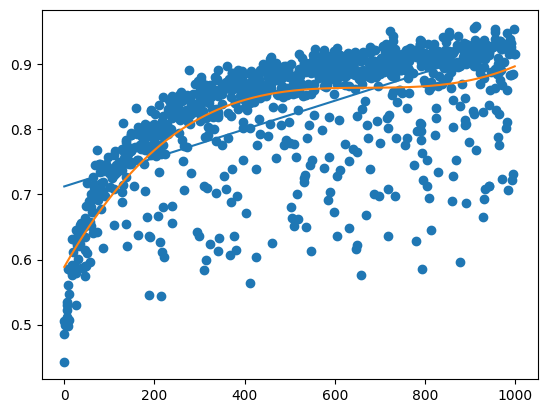

In [77]:
import sklearn
possese = []
accs = []
steps = 1000
for i in range(steps):
    #print(f"\n\n\nRun #{i}")
    src, targets, pos = next(iter(dl))
    possese.append(pos)
    targets = targets[pos:]
    with torch.no_grad():
        output = model[2](src, single_eval_pos=pos)
    preds = torch.argmax(output, dim=-1).float()
    accuracy =  torch.mean((preds==targets)[targets!=-100].float())
    accs.append(accuracy)
m,b = np.polyfit(possese, accs, 1)
line = np.arange(0,1001,1)*m+b
plt.plot(line)
plt.scatter(possese, accs)

poly_features = sklearn.preprocessing.PolynomialFeatures(degree=3) # decide the maximal degree of the polynomial feature
X_ploy = poly_features.fit_transform(np.array(possese).reshape(-1,1))
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X_ploy,accs)
X_new = np.sort(possese,axis = 0) # in order to plot the line of the model, we need to sort the the value of x-axis
X_new_ploy = poly_features.fit_transform(X_new.reshape(-1,1)) # compute the polynomial features 
y_predict = lin_reg.predict(X_new_ploy)
plt.plot(X_new, y_predict)

In [49]:
def plot_class_dist_bars(bin_avgs):
    step = 1/len(bin_avgs)
    bins = torch.arange(step,1+step,step)
    plt.bar(bins-step, bin_avgs, width=step, align="edge", color="red")
    plt.bar(bins-step, bins-step/2, width=step, align="edge", color="blue", alpha=0.5)
    plt.xlabel = "test"
    plt.show()

In [ ]:
def get_binned_class_avg(model, steps=0.025):
    bins = torch.arange(step,1+step,step)
    bin_preds = [[]for _ in bins]
    for i in range(10000):
        src, targets, pos = next(iter(dl))
        targets = targets[pos:]
        output = model[2](src, single_eval_pos=pos)
        preds = torch.argmax(output, dim=-1).float()
        avg_tgt = torch.mean(targets)
        avg_pred = torch.mean(preds)
        bin_num = torch.min(torch.nonzero(bins>=avg_tgt)).item()
        bin_preds[bin_num].append(avg_pred)
    bin_avgs = [torch.nanmean(torch.tensor(b)) for b in bin_preds]

tensor([0.0250, 0.0500, 0.0750, 0.1000, 0.1250, 0.1500, 0.1750, 0.2000, 0.2250,
        0.2500, 0.2750, 0.3000, 0.3250, 0.3500, 0.3750, 0.4000, 0.4250, 0.4500,
        0.4750, 0.5000, 0.5250, 0.5500, 0.5750, 0.6000, 0.6250, 0.6500, 0.6750,
        0.7000, 0.7250, 0.7500, 0.7750, 0.8000, 0.8250, 0.8500, 0.8750, 0.9000,
        0.9250, 0.9500, 0.9750, 1.0000])
[tensor(0.0001), tensor(0.0038), tensor(0.0160), tensor(0.0379), tensor(0.0578), tensor(0.0828), tensor(0.1007), tensor(0.1250), tensor(0.1527), tensor(0.1848), tensor(0.2035), tensor(0.2447), tensor(0.2615), tensor(0.2944), tensor(0.3232), tensor(0.3451), tensor(0.3893), tensor(0.4081), tensor(0.4461), tensor(0.4856), tensor(0.5168), tensor(0.5466), tensor(0.5816), tensor(0.6170), tensor(0.6469), tensor(0.6752), tensor(0.7058), tensor(0.7329), tensor(0.7728), tensor(0.7961), tensor(0.8262), tensor(0.8444), tensor(0.8662), tensor(0.8972), tensor(0.9184), tensor(0.9394), tensor(0.9634), tensor(0.9803), tensor(0.9950), tensor(0.9948)

<BarContainer object of 40 artists>

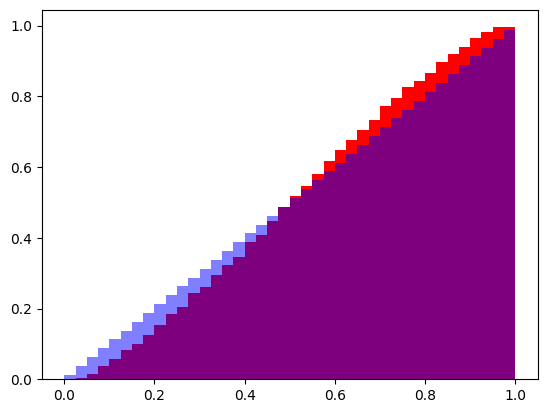

In [44]:
step = 0.025
bins = torch.arange(step,1+step,step)
print(bins)
bin_preds = [[]for _ in bins]
for i in range(10000):
    #print(f"\n\n\nRun #{i}")
    src, targets, pos = next(iter(dl))
    #pos = 800
    #print(src[1].sh=step
    targets = targets[pos:]
    output = model[2](src, single_eval_pos=pos)
    preds = torch.argmax(output, dim=-1).float()
    avg_tgt = torch.mean(targets)
    avg_pred = torch.mean(preds)
    #print(avg_tgt)
    bin_num = torch.min(torch.nonzero(bins>=avg_tgt)).item()
    bin_preds[bin_num].append(avg_pred)
    #accuracy = torch.mean((preds==targets)[targets!=-100].float())
bin_avgs = [torch.nanmean(torch.tensor(b)) for b in bin_preds]
print(bin_avgs)
plt.bar(bins-step, bin_avgs, width=step, align="edge", color="red")
plt.bar(bins-step, bins-step/2, width=step, align="edge", color="blue", alpha=0.5)

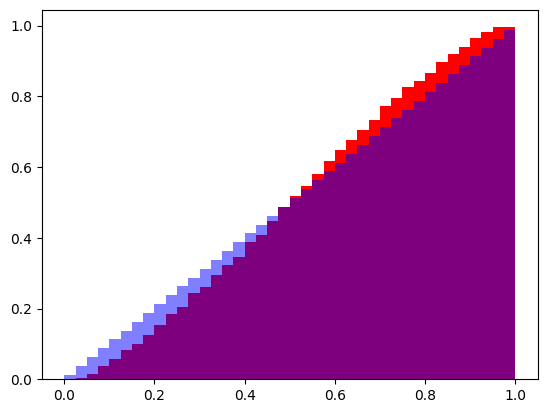

In [50]:
plot_class_dist_bars(bin_avgs)

tensor([2.3026, 0.1054])
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99] [4.60517019 3.91202301 3.5065579  3.21887582 2.99573227 2.81341072
 2.65926004 2.52572864 2.40794561 2.30258509 2.20727491 2.12026354
 2.04022083 1.96611286 1.89711998 1.83258146 1.77195684 1.71479843
 1.66073121 1.60943791 1.56064775 1.51412773 1.46967597 1.42711636
 1.38629436 1.34707365 1.30933332 1.27296568 1.23787436 1.2039728
 1.17118298 1.13943428 1.10866262 1.07880966 1.04982212 1.02165125
 0.99425227 0.96758403 0.94160854 0.91629073 0.89159812 0.86750057
 0.8

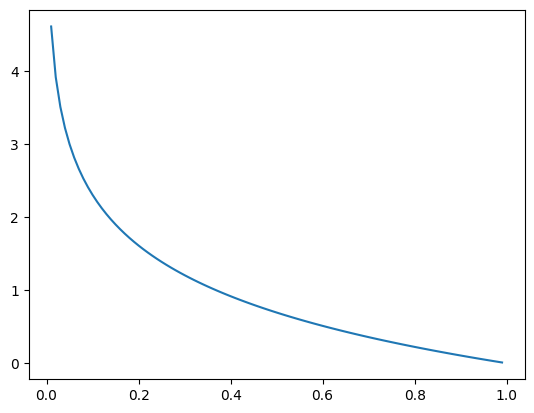

In [22]:
a = torch.tensor([0.1,0.9])
print(-torch.log(a))
b = np.arange(0.01,1,0.01)
print(b, -np.log(b))
plt.plot(b, -np.log(b))